In [5]:
# !git clone https://github.com/tordjx/ummt.git
# import os 
# os.chdir("ummt/Core model files")
# os.getcwd()
!pip install matplotlib --quiet
!pip install livelossplot --quiet
!pip install nltk --quiet
#mc cp s3/tordjx ummt/Core*model*files --recursive
# watch -n 0.5 nvidia-smi
import nltk
nltk.download('wordnet')
image_bool = True
load_model = False

[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 
from greedy_beam_search import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size,True)
tokenized_val_fr,tokenized_val_en, _,_ = get_train_data_nouveau(batch_size,False)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =8
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 512
dropout = 0.3
activation = nn.Softmax(dim=2)
embedding_dim = 128

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],False,'').to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],False,'').to(device)
model_fr.feedforward= model_en.feedforward
for i in range(3):
  model_fr.decoder.layers[i]= model_en.decoder.layers[i]
  model_fr.encoder.layers[i]= model_en.encoder.layers[i]
if load_model : 
    model_en.load_state_dict(torch.load("tordjx/model_en"))
    model_fr.load_state_dict(torch.load("tordjx/model_fr"))
else : 
    with open("logs.txt",'w') as logs :
        logs.write("")
        logs.close()
if image_bool :
    train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
    val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
    train_features = torch.from_numpy(train_features)
    val_features = torch.from_numpy(val_features)
    train_data_fr = [tokenized_fr, train_features]
    train_data_en = [tokenized_en, train_features]
    val_data_fr = [tokenized_val_fr, val_features]
    val_data_en = [tokenized_val_en, val_features]
def save_model(model_en,model_fr,prefix):
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    import os
    import s3fs
    !pip install pandas
    import pandas
    # Create filesystem object
    S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
    fs.upload("tordjx/"+prefix+"_fr","tordjx/"+prefix+"_fr")
    fs.upload("tordjx/"+prefix+"_en","tordjx/"+prefix+"_en")

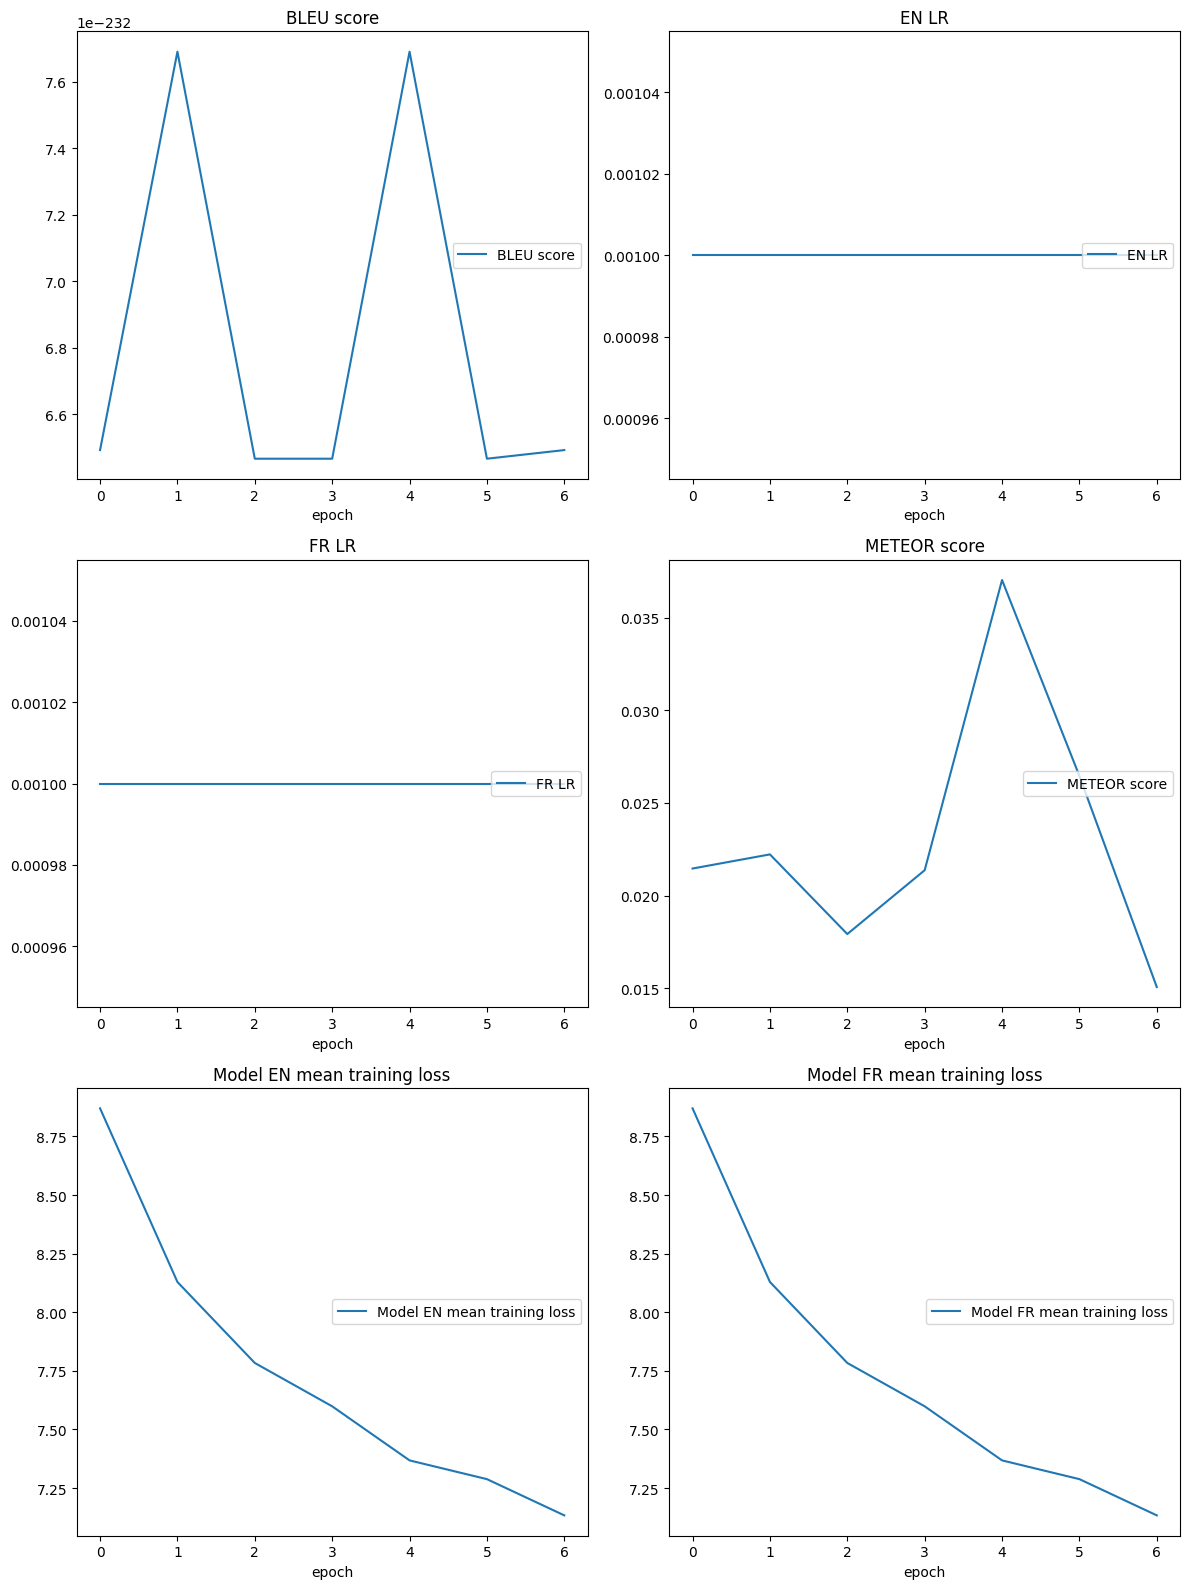

BLEU score
	BLEU score       	 (min:    0.000, max:    0.000, cur:    0.000)
EN LR
	EN LR            	 (min:    0.001, max:    0.001, cur:    0.001)
FR LR
	FR LR            	 (min:    0.001, max:    0.001, cur:    0.001)
METEOR score
	METEOR score     	 (min:    0.015, max:    0.037, cur:    0.015)
Model EN mean training loss
	Model EN mean training loss 	 (min:    7.133, max:    8.870, cur:    7.133)
Model FR mean training loss
	Model FR mean training loss 	 (min:    7.133, max:    8.870, cur:    7.133)


In [ ]:
#On va entrainer 4 modeles : avec/sans images, avec/sans teacher forcing
bools = [True,False]
for image_bool in bools : 
    for teacher_forcing in bools :
        prefix = str(image_bool)+str(teacher_forcing)
        model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
        model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
        model_fr.feedforward= model_en.feedforward
        for i in range(3):
          model_fr.decoder.layers[i]= model_en.decoder.layers[i]
          model_fr.encoder.layers[i]= model_en.encoder.layers[i]
        with open(prefix+"logs.txt",'w') as logs :
            logs.write("")
            logs.close()
        if image_bool :
            mixed_train(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,60,batch_size, True,1/2)
        else :
            mixed_train(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,60,batch_size, False,1/2)
        save_model(model_en,model_fr,prefix)

In [ ]:
# if image_bool :
#     loss_list = learning_rate_finder(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,150,batch_size, True,1/2)
# else :
#     loss_list = learning_rate_finder(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,150,batch_size, False,1/2)

lrs = [10**(-10)*3**n for n in range(len(loss_list))]
cut = 11
begin = 10
plt.plot(lrs[begin:-cut],loss_list[begin:-cut])
plt.xscale('log')
plt.show()

In [ ]:
#Copilot generated code
from torchvision import models, transforms
from PIL import Image
import requests
def relu_layer(x):
    return torch.nn.functional.relu(x)

def open_image(path):
    image = Image.open(path)
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    return image

def get_resnet_features_from_image(image):
    resnet = models.resnet152(pretrained=True)
    resnet.eval()
    resnet = resnet.to(device)
    resnet = nn.Sequential(*list(resnet.children())[:-1])
    image = image.to(device)
    image = image.unsqueeze(0)
    image = resnet(image)
    image = image.squeeze(0)
    return image


from torchtext.data.metrics import bleu_score
def bleu_score(model_fr,model_en,val_data_en,val_data_fr,inv_map_en,inv_map_fr,image_bool) :
    model_fr.eval()
    model_en.eval()
    if image_bool :
        val_data_en,features= tokenized_val_en
        val_data_fr,features= tokenized_val_fr
    else :
        val_data_en,val_data_fr = val_data_en,val_data_fr
    batched_data_en,batched_data_fr=batchify([val_data_en,val_data_fr],batch_size,image_bool)
    if image_bool:
        src,features = batched_data_en
        tgt,_ = batched_data_fr
    else :
        src,tgt = batched_data_en,batched_data_fr
    traductions = []
    references = []
    for batch in range(len(src)):
        if image_bool :
            src[batch],features[batch] = src[batch].to(device),features[batch].to(device)
        else :
            src[batch] = src[batch].to(device)
        tgt[batch] = tgt[batch].to(device)
        traduction = torch.argmax(CCF_greedy(model_en,model_fr,src[batch],features[batch],image_bool) ,dim = 2)
        for i in range(traduction.shape[0]):
            traductions.append(inv_map_fr[traduction[i][j].item()]  for j in range(traduction.shape[1]) if inv_map_fr[traduction[i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"])
            references.append([inv_map_en[tgt[batch][i][j].item()] for j in range(tgt[batch].shape[1]) if inv_map_en[tgt[batch][i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])

    score = bleu_score(outputs, targets)
    return score
def open_image_from_url(url):
    image = Image.open(requests.get(url, stream=True).raw)
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    return image
image = open_image_from_url("https://upload.wikimedia.org/wikipedia/commons/5/53/Shadow_2752.jpg")
image = get_resnet_features_from_image(image)
image.shape

In [ ]:
def moving_average(a, n=1,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
print(len(model_fr.loss_list)/(29000/batch_size))


In [ ]:
tokenized_val_en = val_data_en[0]
i = np.random.randint(len(tokenized_val_en)//batch_size)
j = np.random.randint(batch_size)
src,features,tgt = donne_random(i,j,val_data_en,val_data_fr,batch_size,True)
features = features.to(device,dtype=torch.float32)
data = [src,features]
# OUT= traduit('greedy',model_en,model_fr,data, inv_map_en,True,tgt[j],inv_map_fr,j)
OUT = greedy_beam_search.CCF_greedy(model_en,model_fr,src, features, True)
values,indices = torch.topk(OUT,2,2)
print(values)
print(indices)